# Build Voting Classifier Models

## Import Processed Data

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
# set path of the processed data
processed_data_path = Path.cwd().parent / 'data' / 'processed'
train_processed_file_path = processed_data_path /'train_processed_for_pca.csv'
test_processed_file_path = processed_data_path / 'test_processed_for_pca.csv'
unlabeled_processed_file_path = processed_data_path / 'unlabeled_processed_for_pca.csv'

# create data frames for train, test, and unlabled data
train_df = pd.read_csv(train_processed_file_path, index_col = 'PassengerId')
test_df = pd.read_csv(test_processed_file_path, index_col = 'PassengerId')
unlabeled_df = pd.read_csv(unlabeled_processed_file_path, index_col = 'PassengerId')

In [3]:
# in the train and test data, X contains all the columns except Survived
# y is Survived
X_train = train_df.drop(['Survived'], axis = 1)
y_train = train_df['Survived']
X_test = test_df.drop(['Survived'], axis = 1)
y_test = test_df['Survived']

## PCA

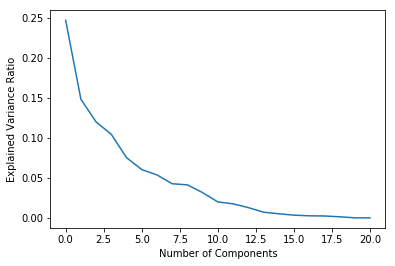

In [4]:
# let's look at how explained variance ratio varies with number of components
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA(random_state = 42)
pca.fit(X_train)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [5]:
# it looks like we can get away with using about 13 components
pca = PCA(n_components = 13,
          random_state = 42).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
unlabeled_pca = pca.transform(unlabeled_df)

## Load persisted models

In [6]:
# create file paths
knn_model_file_path = Path.cwd().parent / 'models' / 'knn_with_pca_model.pkl'
mlp_model_file_path = Path.cwd().parent / 'models' / 'mlp_with_pca_model.pkl'
poly_svc_model_file_path = Path.cwd().parent / 'models' / 'poly_svc_with_pca_model.pkl'
rf_model_file_path = Path.cwd().parent / 'models' / 'rf_with_pca_model.pkl'
logreg_model_file_path = Path.cwd().parent / 'models' / 'logreg_with_pca_model.pkl'

# load
knn_model = joblib.load(knn_model_file_path)
mlp_model = joblib.load(mlp_model_file_path)
poly_svc_model = joblib.load(poly_svc_model_file_path)
rf_model = joblib.load(rf_model_file_path)
logreg_model = joblib.load(logreg_model_file_path)

## Hard Voting with all 5 models

In [7]:
# not sure which is triggering the warning, suppress until I figure that out
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# use 5-fold CV to evaluate accuracy with train data
model = VotingClassifier(estimators = [('knn', knn_model),
                                       ('mlp', mlp_model),
                                       ('poly_svc', poly_svc_model),
                                       ('rf', rf_model),
                                       ('logreg', logreg_model)],
                         voting = 'hard')
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.817429
CV accuracty std: 0.031673
CV scores: [0.7972028  0.79020979 0.83216783 0.87323944 0.79432624]


## Soft Voting with all 5 models

In [8]:
# use 5-fold CV to evaluate accuracy with pca-train data
model.voting = 'soft'
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)

print('CV accuracty mean: ' + '{0:2f}'.format(scores.mean()))
print('CV accuracty std: ' + '{0:2f}'.format(scores.std()))
print('CV scores:', scores)

CV accuracty mean: 0.824462
CV accuracty std: 0.028980
CV scores: [0.81118881 0.79020979 0.83916084 0.87323944 0.80851064]


## Kaggle Score: 0.77511

Before we "go live" with this model (that is, submit its predictions to Kaggle), let's check how it performs on the test data, data that it has never seen and had no influence on its selection:

In [9]:
# fit model to entire train set
model = VotingClassifier(estimators = [('knn', knn_model),
                                       ('mlp', mlp_model),
                                       ('poly_svc', poly_svc_model),
                                       ('rf', rf_model),
                                       ('logreg', logreg_model)],
                         voting = 'soft').fit(X_train_pca, y_train)

# evaluate accuracy on test set
print('Voting Classifier (w/PCA) Accuracy: ' + '{0:2f}'.format(model.score(X_test_pca, y_test)))

Voting Classifier (w/PCA) Accuracy: 0.804469


In [10]:
# generate predictions
predictions = model.predict(unlabeled_pca)

# create a new data frame with two columns: PassengerId and our predicted values for Survived
submission_df = pd.DataFrame({'PassengerId' : unlabeled_df.index, 'Survived' : predictions})

# write submission to disk...
# first define path
submission_file_path = Path.cwd().parent / 'data' / 'external' / 'voting_with_pca.csv'

# create the .csv file
# index is False since we don't want a third column
submission_df.to_csv(submission_file_path, index = False)

## Model Persistence

In [11]:
# create file path
model_file_path = Path.cwd().parent / 'models' / 'voting_with_pca_model.pkl'

# persist the model
joblib.dump(model, model_file_path);

#### Optional: Check the persisted model

In [12]:
# create file paths
model_file_path = Path.cwd().parent / 'models' / 'voting_with_pca_model.pkl'

# load
model_loaded = joblib.load(model_file_path)

In [13]:
# print the model object description
model_loaded

VotingClassifier(estimators=[('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=5,
           weights='uniform')), ('mlp', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_s..., penalty='l1', random_state=42,
          solver='saga', tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [14]:
# calculate the score using the loaded model object
# we should get 0.804469, as above
print('Persisted Voting Accuracy: ' + '{0:2f}'.format(model_loaded.score(X_test_pca, y_test)))

Persisted Voting Accuracy: 0.804469


## Error Analysis

In [15]:
# imports
from sklearn.model_selection import cross_val_predict

In [16]:
# instead of scoring, get the cross-validated estimates for each image
y_train_pred = cross_val_predict(model, X_train_pca, y_train, cv = 5)

In [17]:
# now let's take a look at the confusion matrix to see
# which actual labels (rows) do not match the predicted label (columns)
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

conf_mx = confusion_matrix(y_train, y_train_pred)
print(np.matrix(conf_mx))
print('Precision score: ', precision_score(y_train, y_train_pred))
print('Recall score: ', recall_score(y_train, y_train_pred))
print('F1 score: ', f1_score(y_train, y_train_pred))
print('Area under the ROC curve: ', roc_auc_score(y_train, y_train_pred))

[[393  46]
 [ 81 192]]
Precision score:  0.8067226890756303
Recall score:  0.7032967032967034
F1 score:  0.75146771037182
Area under the ROC curve:  0.7992565521039325


In [18]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda2/envs/mypython3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn'

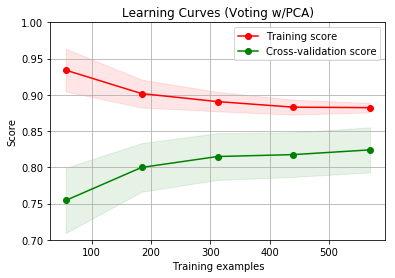

In [19]:
title = "Learning Curves (Voting w/PCA)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(model, title, X_train_pca, y_train, ylim=(0.7, 1.0), cv=cv, n_jobs=-1);

Slight improvement over the non-PCA attempt. I guess I need to think more deeply about feature engineering...tomorrow!